In [41]:
import json
import pandas as pd
from datasets import load_dataset
import getpass
import os
import time

import requests
from langchain_community.tools.tavily_search import TavilySearchResults


In [22]:
with open("/Users/ankushgarg/Downloads/climate_comments.json", 'r') as json_file:
    json_data = json.load(json_file)


In [38]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

In [93]:
_set_env("TAVILY_API_KEY")

In [275]:
import logging
import operator
from typing import Annotated, List, Optional, TypedDict, Sequence
from langchain_core.messages import BaseMessage

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("reddit-comments")

class State(TypedDict):
    prompts: Annotated[Sequence[BaseMessage], operator.add]
    input: Annotated[Sequence[BaseMessage], operator.add]
    replies: Annotated[Sequence[BaseMessage], operator.add]
    keywords: Annotated[Sequence[BaseMessage], operator.add]
    article_search: Annotated[Sequence[BaseMessage], operator.add]
    comment_summaries: Annotated[Sequence[BaseMessage], operator.add]
    generated_reply: Annotated[Sequence[BaseMessage], operator.add]


In [276]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model='claude-3-haiku-20240307')

In [348]:
def extract_keywords_from_title(state: State):
    input = state["input"][-1]
    
    prompt = f"""Extract two most important keywords from the input. Please return them as a Python list of strings. Don't include any preamble, just the keywords in your response.
    input: {input}
    """ # We extracted two keywords from the title

    response = llm.invoke(prompt)
    return {"keywords":[response.content], "prompts": [prompt]}

def tool_search(state: State):
    keywords = state["keywords"][-1]
    
    tool = TavilySearchResults(max_results=1, include_raw_content=True)

    prompt = f"Based on these keywords: {keywords}, please search for an article on the web."

    response = tool.invoke(prompt)
    return {"article_search": [response[0]], "prompts": [prompt]}


def summarize_tone_sentiment_of_replies(state: State):
    content = state["replies"]

    prompt = f"""Your goal is to extract a tone (single), sentiment (single) and summary (less than 100 words) the main point the comments are making. Analyze and output in JSON format with keys: "tone" (tone), "sentiment" (positive or negative), "summary" (main point the replies are making).
    input: {content}
    """
    response = llm.invoke(prompt)
    return {"comment_summaries":[response.content], "prompts": [prompt]}

def generate_reply(state: State):
    url = ""
    content = ""
    tone = ""
    sentiment = ""
    summary = ""

    try: 
        article_search = state.get("article_search")[0]
        url = article_search['url']
        content = article_search['content']
    except Exception as e:
        print(e)
        
    try:
        comment_summaries = json.loads(state.get("comment_summaries")[0])
        tone = comment_summaries['tone']
        sentiment = comment_summaries['sentiment']
        summary = comment_summaries['summary']
        
    except Exception as e:
        print(e)

    prompt = f"""Based on the this headline of the article: {content} and a summary of replies: {summary}, generate a reddit comment (in less than a 100 words) in this tone {tone} and sentiment: {sentiment}. Make sure to include the link to the url {url} in the reply itself. 
    Special instructions: No need to include a heading or any preamble, just report the comment.
"""
    response = llm.invoke(prompt)
    return {"generated_reply":[response.content], "prompts": [prompt]}


In [349]:
from langgraph.graph import StateGraph, Graph, START, END

workflow = StateGraph(State)

workflow.add_node("extract_keywords_from_title", extract_keywords_from_title)
workflow.add_node("tool_search", tool_search)
workflow.add_node("summarize_tone_sentiment_of_replies", summarize_tone_sentiment_of_replies)
workflow.add_node("generate_reply", generate_reply)

workflow.add_edge(START, "extract_keywords_from_title")

workflow.add_edge("extract_keywords_from_title", "tool_search")
workflow.add_edge("tool_search", "summarize_tone_sentiment_of_replies")
workflow.add_edge("summarize_tone_sentiment_of_replies", "generate_reply")
workflow.add_edge("generate_reply", END)

graph = workflow.compile()

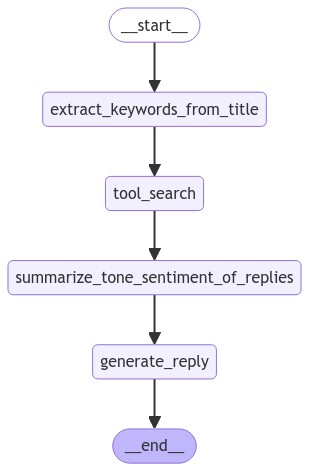

In [350]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)
    # This requires some extra dependencies and is optional
    pass

In [370]:
def write_to_file(response, post_id):
    previous_responses = pd.read_excel("reddit-comments-eval.xlsx", sheet_name="Sheet1")

    try:
        post_id = {f"post_id": post_id}
        prompts = {f"prompt-{idx+1}": r for idx, r in enumerate(response['prompts'])}
        input = {f"input-post": r for _, r in enumerate(response['input'])}
        replies = {f"input-replies": [r for idx, r in enumerate(response['replies'])]}
        keywords = {f"output-keywords": response["keywords"]}
        article_search = {f"output-article_search" : response['article_search']}
        output_replies = {f"output-replies": json.loads(response['comment_summaries'][0])}
        reply = {f"output-reply": response["generated_reply"]}

        response_df = pd.DataFrame([{
            **post_id,
            **prompts, 
            **input, 
            **replies, 
            **keywords,
            **article_search,
            **output_replies,
            **reply
            }]) 
        
        updated_responses = pd.concat([previous_responses, response_df])
        updated_responses.to_excel("reddit-comments-eval.xlsx", sheet_name="Sheet1", index=False)

    except Exception as e:
        print(e)
        updated_responses = pd.concat([previous_responses, pd.DataFrame()])
        updated_responses['error'] = e
        updated_responses.to_excel("reddit-comments-eval.xlsx", sheet_name="Sheet1", index=False)


In [372]:
start = 0
end = 10

responses = {}
for post in json_data['Posts'][start:end]:
    post_id = post['PostID']
    post_title = [post['PostTitle']]
    comments = [i['CommentBody'] for i in post['Comments']]
    
    response = graph.invoke({
        "input": post_title,
        "replies": comments
        })
    responses[str(post_id)] = response



In [374]:
for post_id, response in responses.items():
    write_to_file(response=response, post_id=post_id)